# Análisis de Sentimiento de Tweets con Bag of Words

## Introducción

En este cuaderno Jupyter, se ha diseñado, programado y evaluado un modelo de tipo Bag of Words para realizar análisis de sentimiento sobre un dataset de Tweets. A continuación, se describen los pasos seguidos para resolver el ejercicio planteado:

### Obtención del Dataset y Preprocesamiento

Se utilizó la librería NLTK para obtener el dataset de Tweets. Los tweets positivos y negativos fueron descargados y preprocesados mediante una serie de técnicas de limpieza, tokenización y stemming. El preprocesamiento incluyó la eliminación de URLs, menciones, hashtags y stopwords, así como la reducción de palabras a su raíz mediante el algoritmo de Porter Stemmer.

### Cálculo de 1-gramas y 2-gramas

Para la representación de los tweets, se utilizó la técnica de Bag of Words, calculando tanto 1-gramas como 2-gramas. Esto se logró mediante el uso de la clase `CountVectorizer` de la librería scikit-learn, configurada para considerar n-gramas de longitud 1 y 2.

### División del Dataset en Train y Test

El dataset fue dividido en conjuntos de entrenamiento y prueba. El conjunto de entrenamiento se utilizó para realizar la validación cruzada y la optimización de hiperparámetros, mientras que el conjunto de prueba se utilizó para realizar una evaluación final de los modelos.

### Construcción de Modelos Predictivos

Además de la regresión logística vista en clase, que utilizaré como Baseline, se construyeron y evaluaron otros modelos predictivos utilizando la representación Bag of Words. Los modelos considerados fueron:
- Regresión Logística (Baseline)
- Máquina de Vectores de Soporte (SVM)
- Árbol de Decisión
- Random Forest

### Evaluación y Comparación de Modelos

Para la evaluación y comparación de los modelos, se utilizaron diversas métricas de clasificación como accuracy, precisión, recall y F1-score. Además, se implementaron técnicas de validación cruzada y optimización de hiperparámetros mediante `GridSearchCV` para asegurar la solidez del análisis. También se graficaron la matriz de confusión y las cajas y bigotes de los resultados obtenidos en los diferentes modelos.

### Conclusión

El análisis realizado permitió comparar el desempeño de diferentes modelos predictivos en la tarea de análisis de sentimiento de Tweets, destacando la importancia del preprocesamiento y la optimización de hiperparámetros para obtener resultados robustos y confiables.

# Código

In [1]:
!pip install nltk numpy pandas matplotlib scikit-learn seaborn

Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 24.0 -> 24.2
[notice] To update, run: pip install --upgrade pip


In [2]:
# Importar las librerías necesarias
import nltk
from nltk.corpus import twitter_samples
from nltk.corpus import stopwords
from nltk.tokenize import TweetTokenizer
from nltk.stem import PorterStemmer
import re
import string
from nltk import ngrams
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import classification_report, roc_curve, auc, precision_recall_curve, confusion_matrix
import matplotlib.pyplot as plt


# Descargar los datos y stopwords
nltk.download('twitter_samples')
nltk.download('stopwords')

# Cargar los tweets positivos y negativos
all_positive_tweets = twitter_samples.strings('positive_tweets.json')
all_negative_tweets = twitter_samples.strings('negative_tweets.json')

# Función para preprocesar los tweets
def process_tweet(tweet):
    stemmer = PorterStemmer()
    stopwords_english = stopwords.words('english')
    
    tweet = re.sub(r'https?://[^\s\n\r]+', '', tweet)
    tweet = re.sub(r'^RT[\s]+', '', tweet)
    tweet = re.sub(r'@\w+', '', tweet)
    tweet = re.sub(r'#', '', tweet)
    
    tokenizer = TweetTokenizer(preserve_case=False, strip_handles=True, reduce_len=True)
    tweet_tokens = tokenizer.tokenize(tweet)
    
    tweets_clean = []
    for word in tweet_tokens:
        if word not in stopwords_english and word not in string.punctuation:
            stem_word = stemmer.stem(word)
            tweets_clean.append(stem_word)
    
    return tweets_clean

# Preprocesar los tweets
cleaned_positive_tweets = [process_tweet(tweet) for tweet in all_positive_tweets]
cleaned_negative_tweets = [process_tweet(tweet) for tweet in all_negative_tweets]

# Unir los tweets positivos y negativos
all_cleaned_tweets = cleaned_positive_tweets + cleaned_negative_tweets
labels = [1] * len(cleaned_positive_tweets) + [0] * len(cleaned_negative_tweets)

# Crear la representación Bag of Words con 1-gramas y 2-gramas
vectorizer = CountVectorizer(ngram_range=(1, 2), tokenizer=lambda x: x, preprocessor=lambda x: x)
features = vectorizer.fit_transform(all_cleaned_tweets)

print('Número de características:', features.shape[1])
print('Ejemplo de características:', vectorizer.get_feature_names_out()[:10])
print('Número de ejemplos:', features.shape[0])
print('Ejemplo de etiquetas:', labels[:10])


[nltk_data] Downloading package twitter_samples to
[nltk_data]     /home/vscode/nltk_data...
[nltk_data]   Package twitter_samples is already up-to-date!
[nltk_data] Downloading package stopwords to /home/vscode/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Número de características: 52919
Ejemplo de características: ['(-:' '(-: jesu' '(:' '(: (:' '(: :(' '(: exo' '(: sweet' '(: ♡' '):'
 '): ):']
Número de ejemplos: 10000
Ejemplo de etiquetas: [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


/home/vscode/.local/lib/python3.12/site-packages/sklearn/feature_extraction/text.py:521: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


In [3]:
# Dividir los datos en entrenamiento y prueba
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.3, random_state=42)

In [4]:
# Hiperparámetros para Regresión Logística
log_param_grid = {
    'C': [0.01, 0.1, 1, 10],
    'solver': ['lbfgs', 'liblinear']
}

# Hiperparámetros para SVM
svm_param_grid = {
    'C': [0.1, 1],
    'kernel': ['linear', 'rbf']
}

# Hiperparámetros para Árbol de Decisión
tree_param_grid = {
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5]
}

# Hiperparámetros para Random Forest
forest_param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5]
}

# Optimización con GridSearchCV para Regresión Logística
log_grid_search = GridSearchCV(LogisticRegression(max_iter=200), log_param_grid, cv=5, scoring='accuracy')
log_grid_search.fit(X_train, y_train)
best_log_model = log_grid_search.best_estimator_
print(f"Best parameters (Logistic Regression): {log_grid_search.best_params_}")
print(f"Best CV Accuracy (Logistic Regression): {log_grid_search.best_score_}")

# Optimización con GridSearchCV para SVM
svm_grid_search = GridSearchCV(SVC(probability=True), svm_param_grid, cv=5, scoring='accuracy')
svm_grid_search.fit(X_train, y_train)
best_svm_model = svm_grid_search.best_estimator_
print(f"Best parameters (SVM): {svm_grid_search.best_params_}")
print(f"Best CV Accuracy (SVM): {svm_grid_search.best_score_}")

# Optimización con GridSearchCV para Árbol de Decisión
tree_grid_search = GridSearchCV(DecisionTreeClassifier(), tree_param_grid, cv=5, scoring='accuracy')
tree_grid_search.fit(X_train, y_train)
best_tree_model = tree_grid_search.best_estimator_
print(f"Best parameters (Decision Tree): {tree_grid_search.best_params_}")
print(f"Best CV Accuracy (Decision Tree): {tree_grid_search.best_score_}")


# Optimización con GridSearchCV para Random Forest
forest_grid_search = GridSearchCV(RandomForestClassifier(), forest_param_grid, cv=5, scoring='accuracy')
forest_grid_search.fit(X_train, y_train)
best_forest_model = forest_grid_search.best_estimator_
print(f"Best parameters (Random Forest): {forest_grid_search.best_params_}")
print(f"Best CV Accuracy (Random Forest): {forest_grid_search.best_score_}")



Best parameters (Logistic Regression): {'C': 10, 'solver': 'lbfgs'}
Best CV Accuracy (Logistic Regression): 0.9955714285714287
Best parameters (SVM): {'C': 1, 'kernel': 'linear'}
Best CV Accuracy (SVM): 0.9957142857142858
Best parameters (Decision Tree): {'max_depth': 10, 'min_samples_split': 5}
Best CV Accuracy (Decision Tree): 0.9941428571428572
Best parameters (Random Forest): {'max_depth': None, 'min_samples_split': 5, 'n_estimators': 100}
Best CV Accuracy (Random Forest): 0.9954285714285713


In [5]:
# show the classification report of classification_report log_grid_search.best_estimator_ results
print("Logistic Regression")
print(classification_report(y_test, best_log_model.predict(X_test)))
print("SVM")
print(classification_report(y_test, best_svm_model.predict(X_test)))
print("Decision Tree")
print(classification_report(y_test, best_tree_model.predict(X_test)))
print("Random Forest")
print(classification_report(y_test, best_forest_model.predict(X_test)))



Logistic Regression
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1463
           1       1.00      1.00      1.00      1537

    accuracy                           1.00      3000
   macro avg       1.00      1.00      1.00      3000
weighted avg       1.00      1.00      1.00      3000

SVM
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1463
           1       1.00      1.00      1.00      1537

    accuracy                           1.00      3000
   macro avg       1.00      1.00      1.00      3000
weighted avg       1.00      1.00      1.00      3000

Decision Tree
              precision    recall  f1-score   support

           0       1.00      0.99      1.00      1463
           1       0.99      1.00      1.00      1537

    accuracy                           1.00      3000
   macro avg       1.00      1.00      1.00      3000
weighted avg       1.00      1.00   

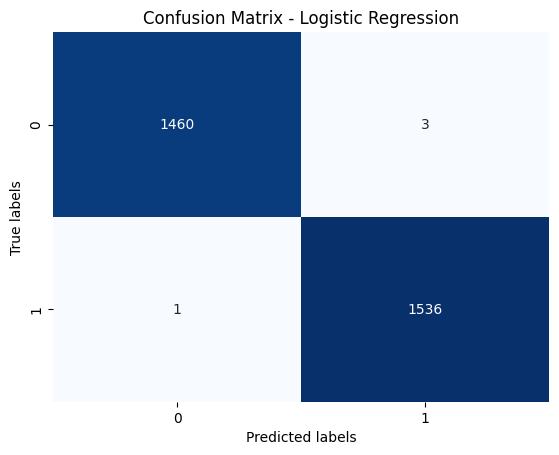

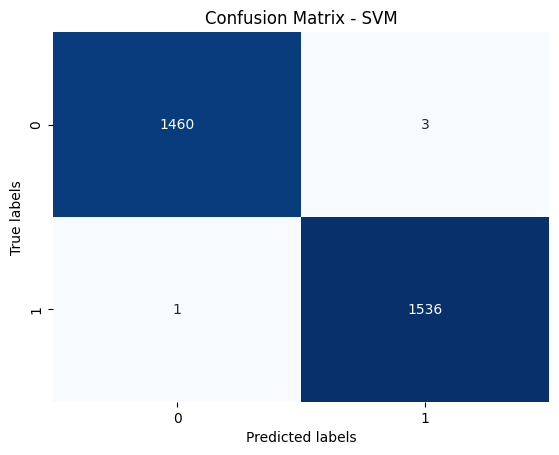

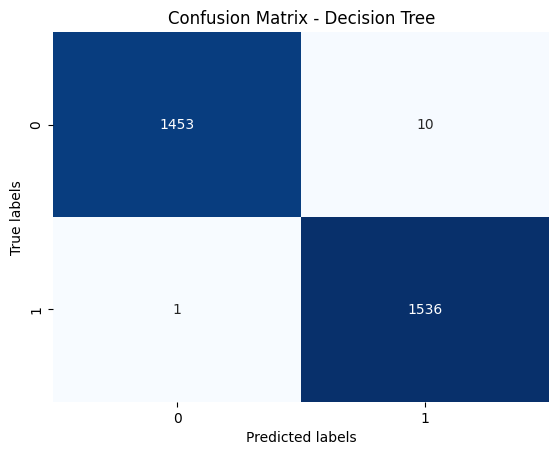

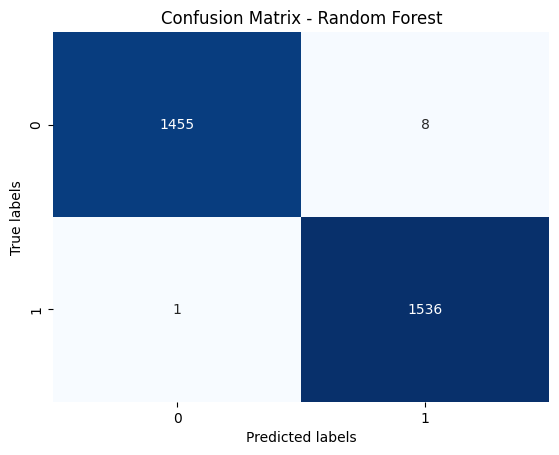

In [6]:

import seaborn as sns


# Función para graficar la matriz de confusión
def plot_confusion_matrix(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.xlabel('Predicted labels')
    plt.ylabel('True labels')
    plt.title(f'Confusion Matrix - {title}')
    plt.show()

# Graficar la matriz de confusión para los modelos
plot_confusion_matrix(y_test, best_log_model.predict(X_test), 'Logistic Regression')
plot_confusion_matrix(y_test, best_svm_model.predict(X_test), 'SVM')
plot_confusion_matrix(y_test, best_tree_model.predict(X_test), 'Decision Tree')
plot_confusion_matrix(y_test, best_forest_model.predict(X_test), 'Random Forest')


Logistic Regression: mean 0.9956666666666667  std 0.0035901098714230073 max 1.0  min 0.99
SVM: mean 0.9960000000000001  std 0.0034318767136623327 max 1.0  min 0.99
Decision Tree: mean 0.9960000000000001  std 0.0034318767136623327 max 1.0  min 0.99
Random Forest: mean 0.9959999999999999  std 0.0030912061651652296 max 1.0  min 0.9916666666666667


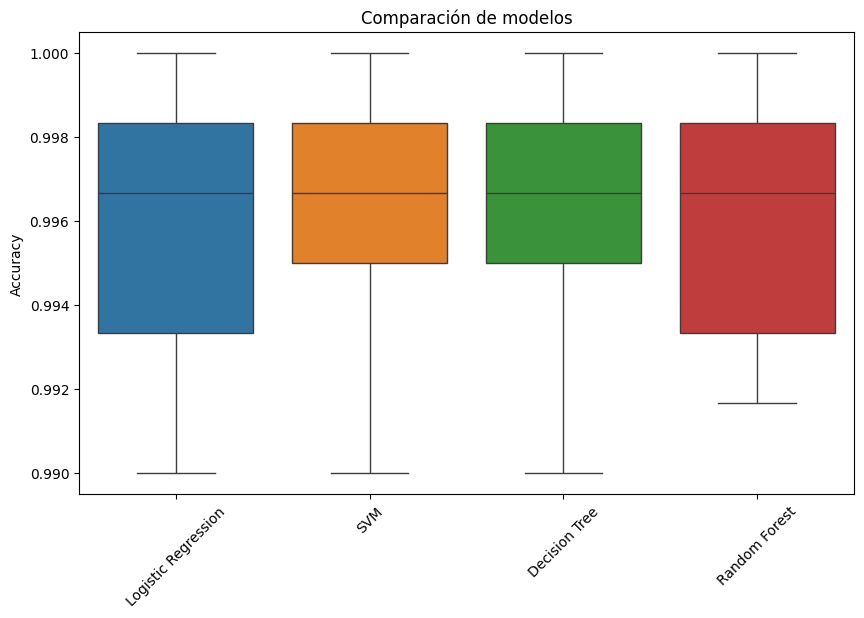

In [7]:
from sklearn.model_selection import cross_val_score
import numpy as np
import pandas as pd



results = {}
results['Logistic Regression'] = cross_val_score(best_log_model, X_test, y_test, cv=5)
results['SVM'] = cross_val_score(best_svm_model, X_test, y_test, cv=5)
results['Decision Tree'] = cross_val_score(best_tree_model, X_test, y_test, cv=5)
results['Random Forest'] = cross_val_score(best_forest_model, X_test, y_test, cv=5)

# Resultados
for name, scores in results.items():
    print(f'{name}: mean {np.mean(scores)}  std {np.std(scores)} max {np.max(scores)}  min {np.min(scores)}')

# Gráfico de cajas y bigotes
plt.figure(figsize=(10, 6))
sns.boxplot(data=pd.DataFrame(results))
plt.title('Comparación de modelos')
plt.ylabel('Accuracy')
plt.xticks(rotation=45)
plt.show()